**Importing data from kaggle**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ciplab/real-and-fake-face-detection")

print("Path to dataset files:", path)

100%|██████████| 431M/431M [00:08<00:00, 56.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ciplab/real-and-fake-face-detection/versions/1


In [ ]:
import os
print("Files in the dataset directory:",os.listdir(path))

Files in the dataset directory: ['real_and_fake_face', 'real_and_fake_face_detection']


In [ ]:
# Check the contents of the 'real_and_fake_face' folder
real_and_fake_face_path = os.path.join(path, 'real_and_fake_face')
print("Contents of 'real_and_fake_face' folder:", os.listdir(real_and_fake_face_path))

# Check the contents of 'real_and_fake_face_detection' folder
real_and_fake_face_detection_path = os.path.join(path, 'real_and_fake_face_detection')
print("Contents of 'real_and_fake_face_detection' folder:", os.listdir(real_and_fake_face_detection_path))


Contents of 'real_and_fake_face' folder: ['training_fake', 'training_real']
Contents of 'real_and_fake_face_detection' folder: ['real_and_fake_face']


Preprocessing the data:

Changing photos into numpy array

In [ ]:
import os
from PIL import Image
import numpy as np

def preprocess_images_separately(input_folder_real, input_folder_fake, output_file_real, output_file_fake, image_size=(128, 128)):
    # Initialize lists to store images and labels
    images_real = []
    images_fake = []
    labels_real = []  # Label for real images
    labels_fake = []  # Label for fake images

    # Process real images
    for filename in os.listdir(input_folder_real):
        img_path = os.path.join(input_folder_real, filename)
        try:
            img = Image.open(img_path).convert('RGB')  # Convert to RGB
            img = img.resize(image_size)  # Resize the image
            images_real.append(np.array(img))  # Append image as NumPy array
            labels_real.append(0)  # Label 0 for real images
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

    # Process fake images
    for filename in os.listdir(input_folder_fake):
        img_path = os.path.join(input_folder_fake, filename)
        try:
            img = Image.open(img_path).convert('RGB')
            img = img.resize(image_size)
            images_fake.append(np.array(img))  # Append image as NumPy array
            labels_fake.append(1)  # Label 1 for fake images
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

    # Convert to NumPy arrays
    images_real = np.array(images_real)
    images_fake = np.array(images_fake)
    labels_real = np.array(labels_real)
    labels_fake = np.array(labels_fake)

    # Save to .npy files
    np.save(output_file_real, {'images': images_real, 'labels': labels_real})
    np.save(output_file_fake, {'images': images_fake, 'labels': labels_fake})

    print(f"Real images and labels saved to {output_file_real}")
    print(f"Fake images and labels saved to {output_file_fake}")


In [ ]:
# Define the paths to the real and fake image folders
folder_real = os.path.join(real_and_fake_face_path, 'training_real')
folder_fake = os.path.join(real_and_fake_face_path, 'training_fake')

# Output file paths for real and fake images
output_file_real = 'real_images.npy'
output_file_fake = 'fake_images.npy'

# Call the function to preprocess images and save separately
preprocess_images_separately(folder_real, folder_fake, output_file_real, output_file_fake)


Real images and labels saved to real_images.npy
Fake images and labels saved to fake_images.npy


In [ ]:
# Load the real and fake image datasets
real_data = np.load('real_images.npy', allow_pickle=True).item()
fake_data = np.load('fake_images.npy', allow_pickle=True).item()

# Extract the images and labels
real_images = real_data['images']
real_labels = real_data['labels']
fake_images = fake_data['images']
fake_labels = fake_data['labels']

# Print the shapes of the datasets
print(f"Real images shape: {real_images.shape}")
print(f"Fake images shape: {fake_images.shape}")


Real images shape: (1081, 128, 128, 3)
Fake images shape: (960, 128, 128, 3)


**Visualizing the photos**

In [ ]:
import matplotlib.pyplot as plt

# Function to display images
def show_images(images, labels, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()


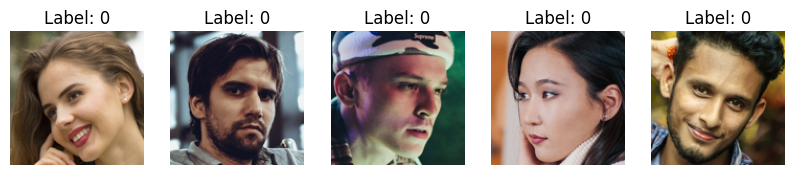

In [ ]:
show_images(real_images,real_labels,num_images=5)

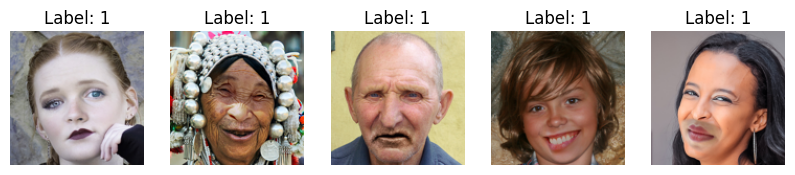

In [ ]:
show_images(fake_images,fake_labels,num_images=5)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , Dense , Flatten , Reshape , LeakyReLU , Dropout , UpSampling2D

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Reshape, UpSampling2D, Conv2D

def build_generator():
    model = Sequential()

    # Takes in random values and reshape it to 4x4x128
    model.add(Dense(4*4*128, input_dim=100))  # Input noise is 100-dimensional
    model.add(LeakyReLU(0.2))
    model.add(Reshape((4, 4, 128)))  # Reshaping to a 4x4x128 tensor

    # Upsampling Block 1:
    model.add(UpSampling2D())  # Upsampling to 8x8x128
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling Block 2:
    model.add(UpSampling2D())  # Upsampling to 16x16x128
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling Block 3:
    model.add(UpSampling2D())  # Upsampling to 32x32x128
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling Block 4:
    model.add(UpSampling2D())  # Upsampling to 64x64x128
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Final Upsampling to 128x128
    model.add(UpSampling2D())  # Upsampling to 128x128x128
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolution layer to output 128x128x3 (RGB image)
    model.add(Conv2D(3, 3, padding='same', activation='tanh'))  # RGB output with tanh activation

    return model


In [ ]:
generator = build_generator()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
generator.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 2048)                │         206,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 128)           │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_6 (UpSampling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 16, 16, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_12 (LeakyReLU)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_7 (UpSampling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 32, 32, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_13 (LeakyReLU)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_8 (UpSampling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 64, 64, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_14 (LeakyReLU)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_9 (UpSampling2D)       │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 128, 128, 128)       │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_15 (LeakyReLU)           │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 128, 128, 3)         │           3,459 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,258,947 (8.62 MB)

 Trainable params: 2,258,947 (8.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
img = generator.predict(np.random.randn(4,100))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [ ]:
img.shape

(4, 128, 128, 3)

The above 4,128,128,3 means:

4: 4 images are being generated at once

128 : height of the image

128 : width of the image

3: RGB-> 3 channels

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


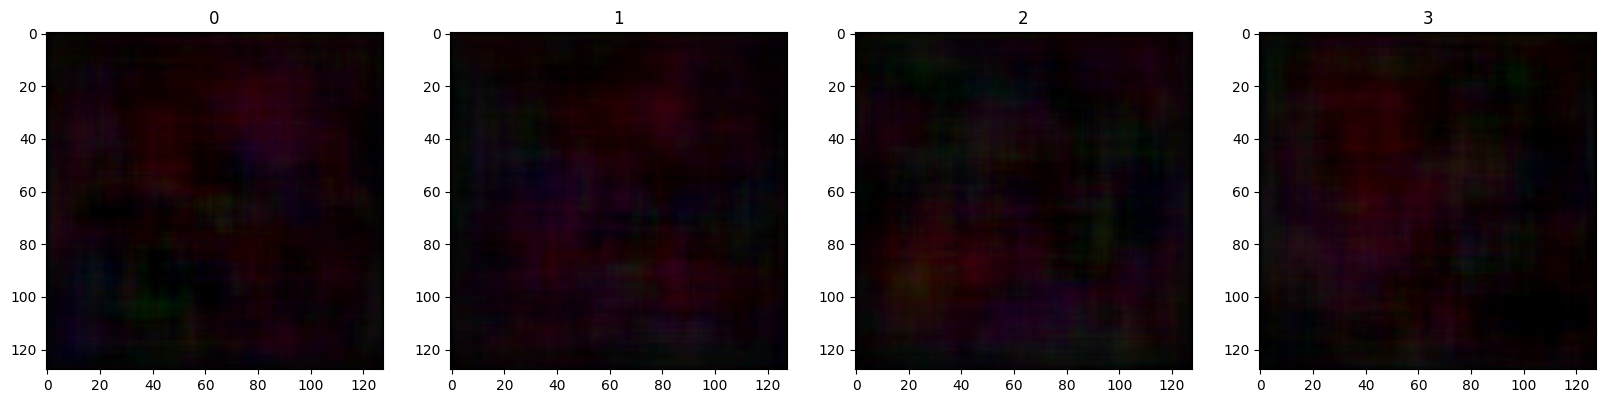

In [ ]:
# Generating new images
img = generator.predict(np.random.randn(4,100))
fig , ax = plt.subplots(ncols=4 ,figsize=(20,20))
# Loop four times and get images
for idx, img in enumerate(img):
  # Plot the image using a specific subplot
  ax[idx].imshow(np.squeeze(img))
  # Appending the image label as the plot title
  ax[idx].title.set_text(idx)

**Building the discriminator and generator**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, Dropout, Flatten, Dense

def build_discriminator():
    model = Sequential()

    # First Block
    model.add(Conv2D(32, 5, input_shape=(128, 128, 3), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second Block
    model.add(Conv2D(64, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Third Block
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Fourth Block
    model.add(Conv2D(256, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten
    model.add(Flatten())
    model.add(Dropout(0.4))

    # Output Layer (real vs fake)
    model.add(Dense(1, activation='sigmoid'))

    return model


In [ ]:
discriminator = build_discriminator()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
discriminator.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 128, 128, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_16 (LeakyReLU)           │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 128, 128, 64)        │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_17 (LeakyReLU)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 128, 128, 128)       │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_18 (LeakyReLU)           │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 128, 128, 256)       │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_19 (LeakyReLU)           │ (None, 128, 128, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128, 128, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4194304)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 4194304)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │       4,194,305 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,272,385 (20.11 MB)

 Trainable params: 5,272,385 (20.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
img.shape

(128, 128, 3)

In [ ]:
discriminator.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


array([[0.5000071 ],
       [0.49966145],
       [0.5006306 ],
       [0.50031435]], dtype=float32)

**Constructing the training loop**

i. Setup the losses and optimizers

In [ ]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary Cross entropy is going to be the loss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
g_opt = Adam(learning_rate = 0.0001)
d_opt = Adam(learning_rate = 0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

ii. Build Subclasses Model

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
import tensorflow as tf

In [ ]:
class ImageGAN(tf.keras.Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.g_opt = Adam(learning_rate=0.0001)  # Initialize optimizer here
        self.d_opt = Adam(learning_rate=0.00001)  # Initialize optimizer here
        self.g_loss = BinaryCrossentropy()
        self.d_loss = BinaryCrossentropy()

    def compile(self, *args, **kwargs):
        super().compile(*args, **kwargs)

    def build(self, input_shape):
        super().build(input_shape)
        # Initialize the optimizer variables by performing a dummy train step
        dummy_batch = tf.zeros((input_shape[0], *input_shape[1:]))
        self.train_step(dummy_batch)

    def call(self, inputs, training=False):
        noise = tf.random.normal((tf.shape(inputs)[0], 100))  # Generate noise based on input batch size
        return self.generator(noise, training=training)

    def train_step(self, batch):
        real_images = batch
        batch_size = tf.shape(real_images)[0]

        # Generate fake images using the generator
        noise = tf.random.normal((batch_size, 100))  # latent vector for batch_size
        fake_images = self.generator(noise, training=False)

        # Train Discriminator
        with tf.GradientTape() as d_tape:
            # Get predictions from discriminator for both real and fake images
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)

            # Concatenate real and fake predictions for the discriminator
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add noise to labels for real and fake (label smoothing)
            noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Compute total loss for discriminator
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Update discriminator's weights
        d_grad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(d_grad, self.discriminator.trainable_variables))

        # Train Generator
        with tf.GradientTape() as g_tape:
            gen_images = self.generator(noise, training=True)
            predicted_labels = self.discriminator(gen_images, training=False)
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Update generator's weights
        g_grad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(g_grad, self.generator.trainable_variables))

        return {"d_loss": total_d_loss, "g_loss": total_g_loss}



In [ ]:
Imagegan = ImageGAN(generator, discriminator)

In [ ]:
Imagegan.compile()

iii. Callback

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import array_to_img

class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=100): # Changed latent_dim to 100
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.image_dir = 'images_new'
        if not os.path.exists(self.image_dir):
            os.makedirs(self.image_dir)

    def on_epoch_end(self, epoch, logs=None):
        # Create random latent vectors for image generation
        random_latent_vectors = tf.random.normal((self.num_img, self.latent_dim))

        # Generate images using the generator
        generated_images = self.model.generator(random_latent_vectors, training=False)

        # Convert the images to the range [0, 255] for saving
        generated_images = (generated_images + 1) * 127.5  # Rescale to [0, 255]
        generated_images = tf.cast(generated_images, tf.uint8)

        # Save the generated images
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join(self.image_dir, f'generated_img_{epoch}_{i}.png'))

monitor = ModelMonitor()

In [ ]:
monitor = ModelMonitor()

iv. Training the model

In [ ]:
real_images.shape

(1081, 128, 128, 3)

In [ ]:
history = Imagegan.fit(real_images, epochs=200, batch_size=32, callbacks=[monitor])

Epoch 1/200
 1/34 ━━━━━━━━━━━━━━━━━━━━ 2:01:53 222s/step - d_loss: 3.1620 - g_loss: 0.6826

KeyboardInterrupt: 